# <center><b> Práctica 2 de Laboratorio 5 </b><br><u> Espectroscopía Láser </u></center>

Grupo 1: Trinidad Borrel, Bruno Sivilotti, Agustín Brusco

In [52]:
import numpy as np
import scipy.constants as cte
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
# Formato para matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.xmargin'] = 0

SCALE = {'m': 1e3, 'μ': 1e6, 'n': 1e9, 'p': 1e12,
         'k': 1e-3, 'M': 1e-6, 'G': 1e-9, 'T': 1e-12}


def corriente_a_frecuencia(corriente: np.ndarray,
                           freqs_forzadas: np.ndarray,
                           corrientes_forzadas: np.ndarray,
                           ) -> np.ndarray:
    """Transforma un array de corrientes con las que se alimentó
    el láser en un array de frecuencias del haz emitido asumiendo
    una relacion de proporcionalidad inversa entre ambas cantidades
    (esto es, al mínimo valor de corriente queda asociado el máximo
    de frecuencia, y viceversa).
    """
    m = -((freqs_forzadas.max() - freqs_forzadas.min())
          / (corrientes_forzadas.max() - corrientes_forzadas.min()))
    return m*(corriente - corrientes_forzadas.min()) + freqs_forzadas.max()


def lineal(t, a, b):
    return a*t + b

In [55]:
FREQS_RUBIDIO85 = np.array([3.61780000e+08, 3.03573244e+09, 3.77105833e+14, 3.77108868e+14, 3.77256703e+14, 3.77257968e+14, 3.77259738e+14])  # Hz
FREQS_RUBIDIO87 = np.array([8.14500000e+08, 6.83468261e+09, 3.77104391e+14, 3.77105206e+14, 3.77111226e+14, 3.88112040e+14])  # Hz
freqs_rubidio = np.sort(np.concatenate([FREQS_RUBIDIO85, FREQS_RUBIDIO87]))  # Hz
print(*[f"{f*SCALE['G']:.6g} GHz" for f in freqs_rubidio], sep=', ')

0.36178 GHz, 0.8145 GHz, 3.03573 GHz, 6.83468 GHz, 377104 GHz, 377105 GHz, 377106 GHz, 377109 GHz, 377111 GHz, 377257 GHz, 377258 GHz, 377260 GHz, 388112 GHz


In [ ]:
from arc.alkali_atom_data import Rubidium
from arc import LevelPlot

rb_atom = Rubidium()
# rb_atom.getEnergy(n=5, l=0, j=1/2)  # eV

levels = LevelPlot(rb_atom)
levels.makeLevels(5, 20, 0, 3)
levels.drawLevels('GHz')
levels.showPlot()

## Carga de Mediciones

In [80]:
# Ignoramos la lectura de las mediciones a 23,75 °C
# por la falta de picos identificables
Temps_arr = np.arange(21.25, 23.75, 0.25)  # °C
times_arr = np.zeros((Temps_arr.size, 2500))  # s
V1 = np.zeros_like(times_arr)  # V
V2 = np.zeros_like(times_arr)  # V
for i, temp_tag in enumerate(Temps_arr):
    file = f'pendiente{int(temp_tag*100)}.npy'
    times_arr[i], V1[i], V2[i] = np.load(file)
Temps_arr = np.array([Temps_arr]*2500).T  # reshaping for consistency

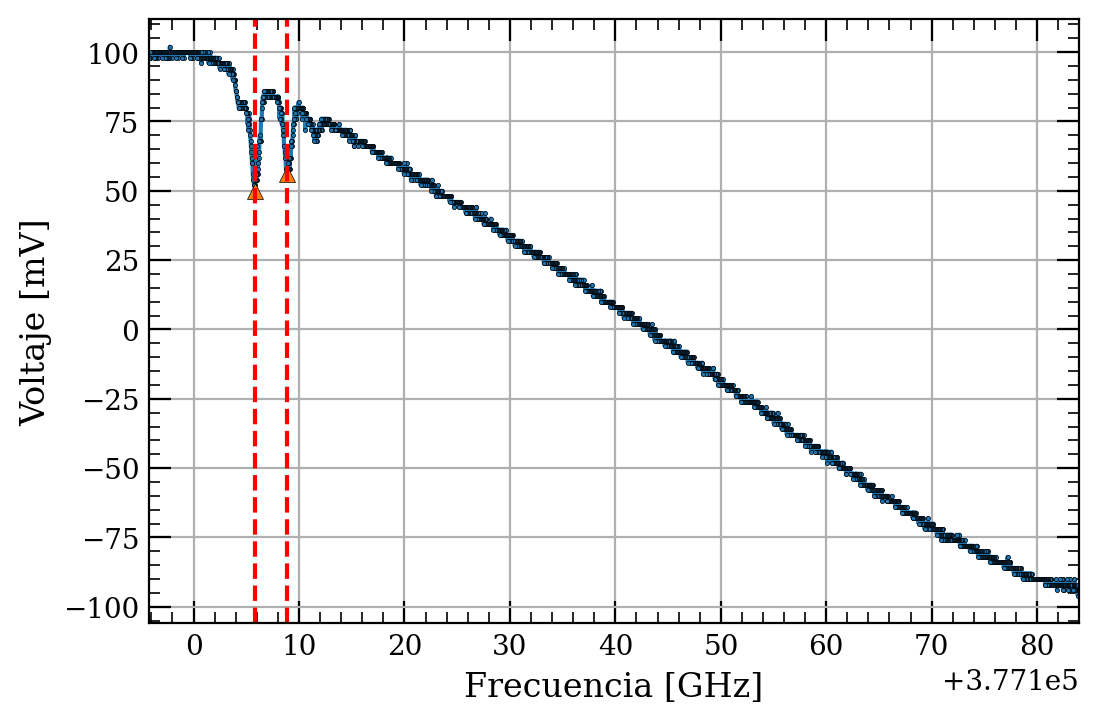

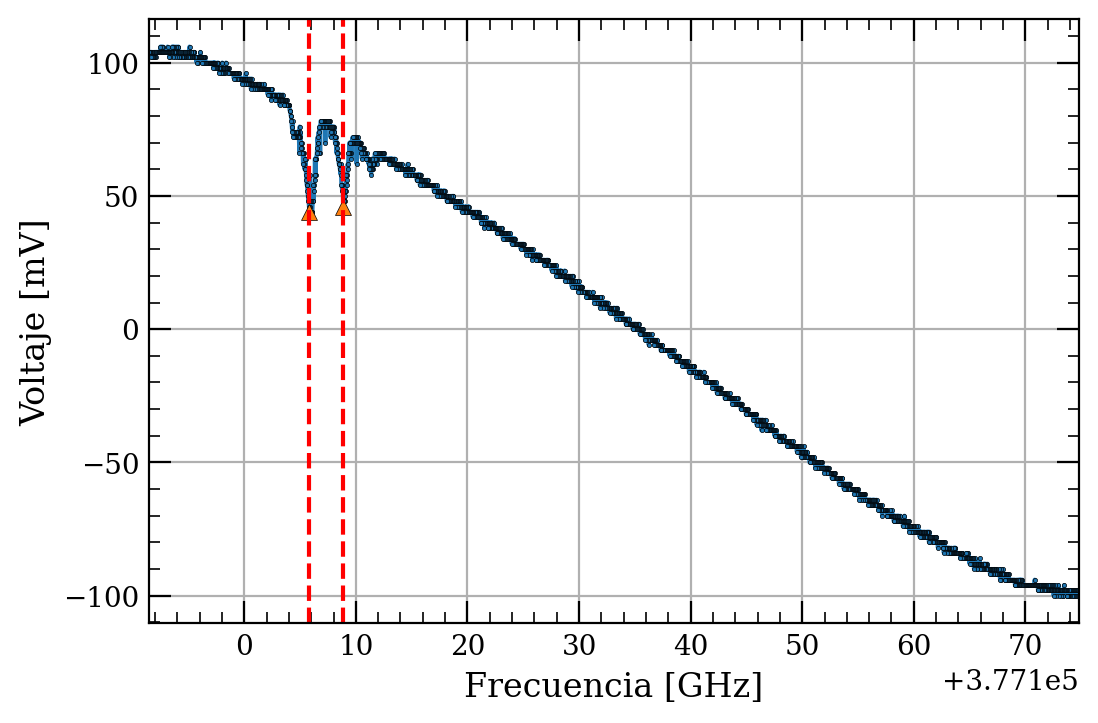

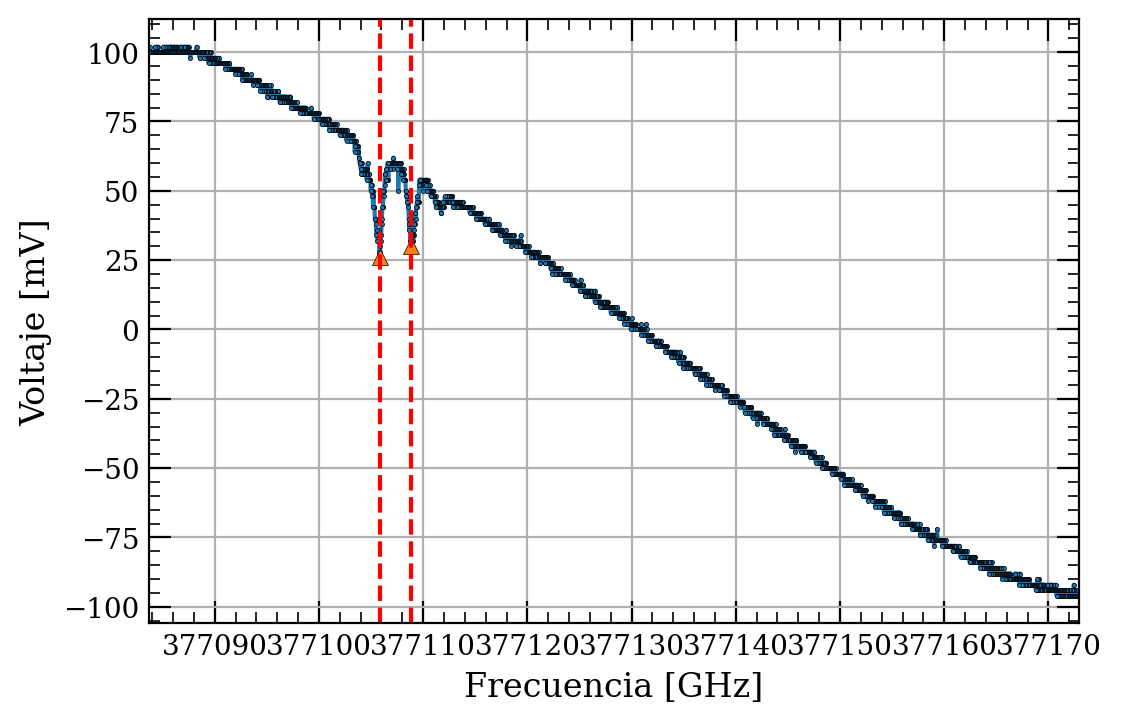

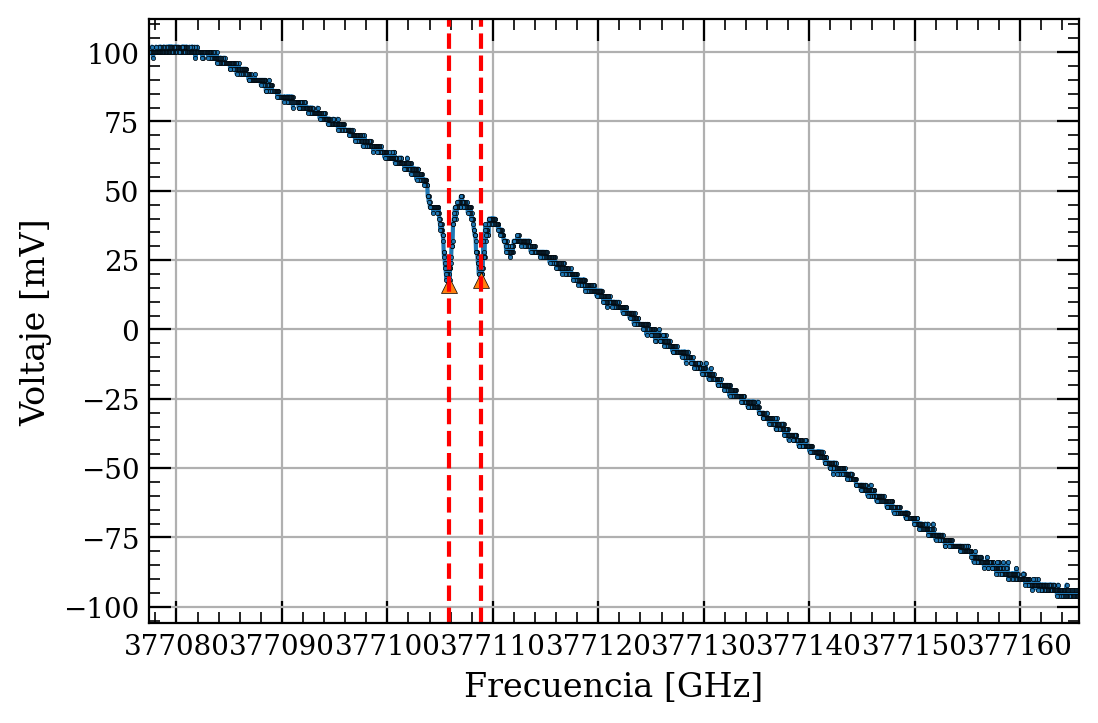

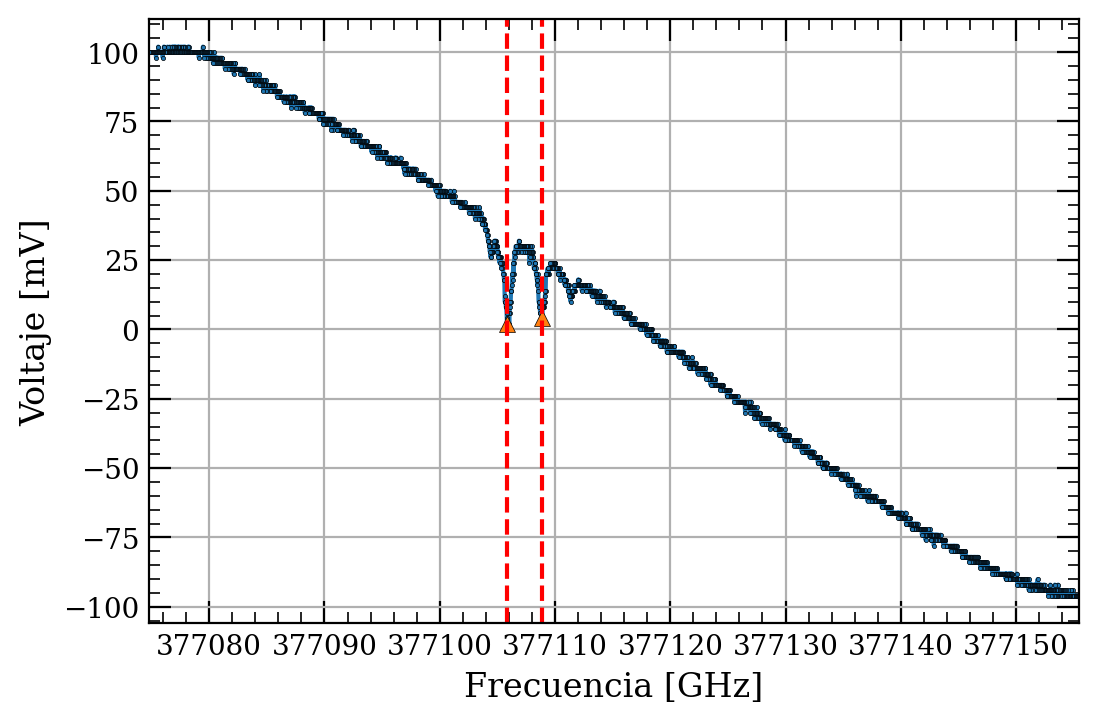

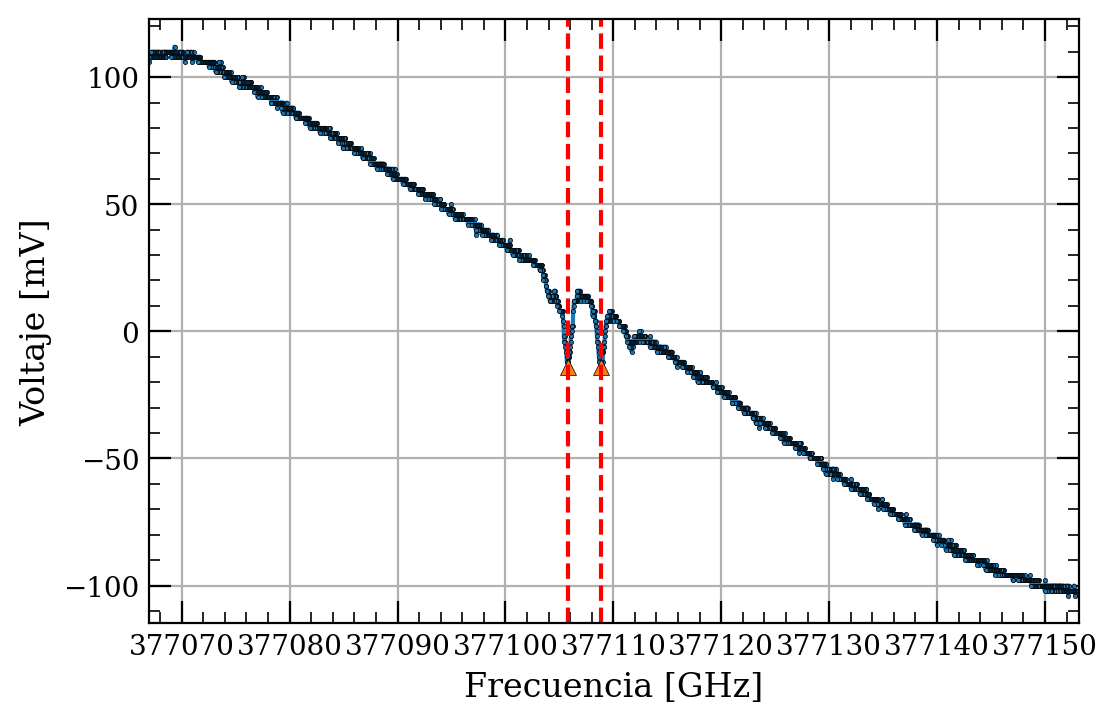

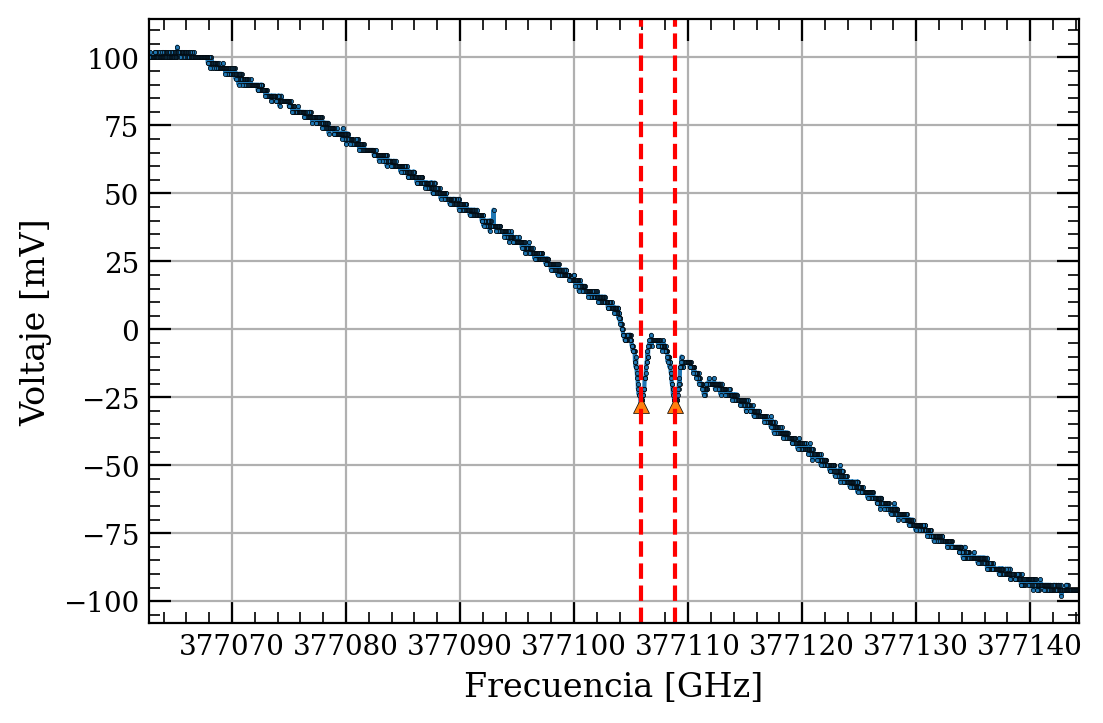

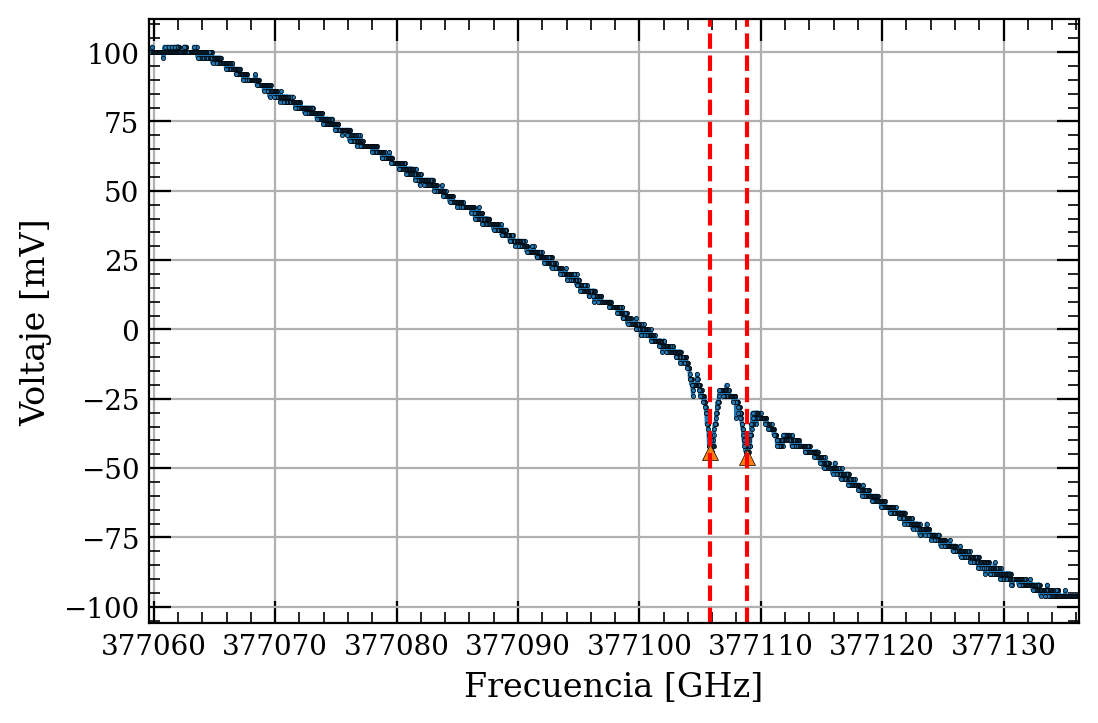

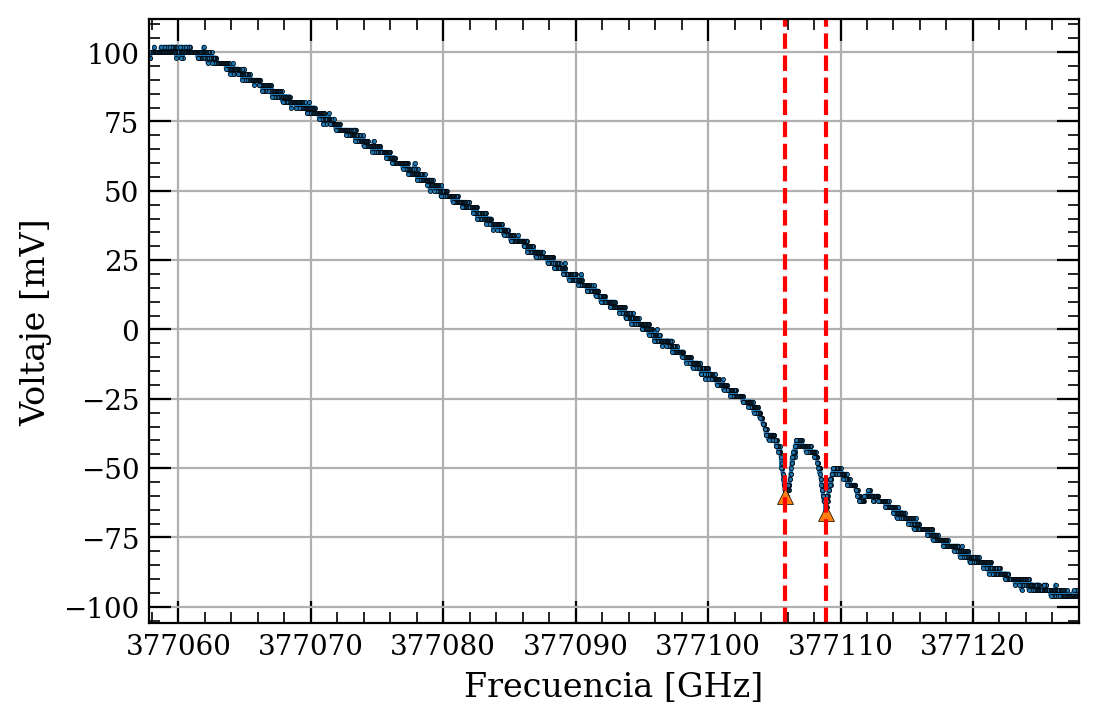

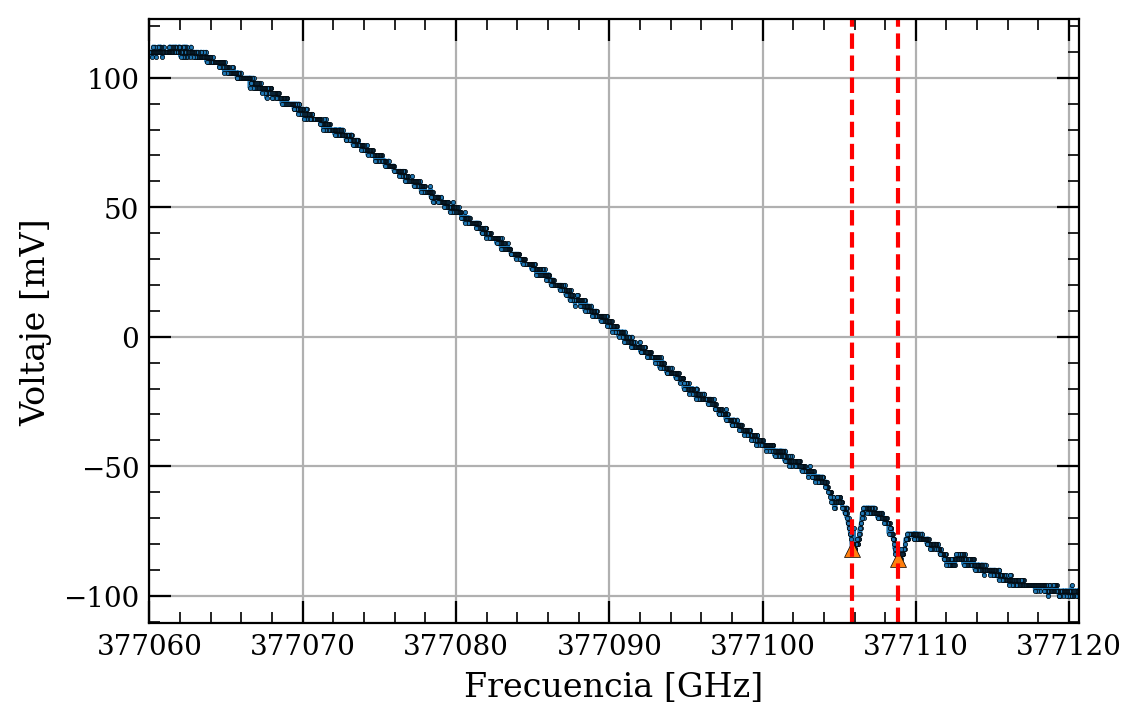

In [81]:
v_units = 'm'
f_units = 'G'
freqs_arr = np.zeros_like(times_arr)
# Hipotesis: los picos de tensión se asocian a los picos de corriente
corriente_setpoint = 1.4e-3  # A : Valor medio de las oscilaciones
corriente_depth = 0.1/100
corriente_max = corriente_setpoint*(1+corriente_depth)  # A
corriente_min = corriente_setpoint*(1-corriente_depth)  # A
corriente_rango = corriente_max - corriente_min  # A
for i, (tiempo, channel1) in enumerate(zip(times_arr, V1)):
    t_max = tiempo[np.argmax(channel1)]  # s
    t_min = tiempo[np.argmin(channel1)]  # s
    m = (corriente_max - corriente_min)/(t_max - t_min)  # A/s

    corriente1 = m*(tiempo - t_min) + corriente_min  # A
    popt, pcov = curve_fit(lineal, corriente1, channel1)

    peaks = find_peaks(-(channel1 - lineal(corriente1, *popt)),
                       distance=30, prominence=0.01, height=0.015)[0]
    
    idx1 = 6
    idx2 = 7
    freqs_arr[i] = corriente_a_frecuencia(corriente1,
                                          freqs_rubidio[[idx1, idx2]],  # Hz
                                          corriente1[peaks[[-2, -1]]])  # A
    
    plt.plot(SCALE[f_units]*freqs_arr[i],
             SCALE[v_units]*channel1,
             '.-', ms=3, mec='k', mew=0.25)
    plt.plot(SCALE[f_units]*freqs_arr[i][peaks],
             SCALE[v_units]*channel1[peaks],
             '^', mec='k', mew=0.25)
    plt.axvline(SCALE[f_units]*freqs_arr[i][peaks[-1]],
                ls='--', c='r')
    plt.axvline(SCALE[f_units]*freqs_arr[i][peaks[-2]],
                ls='--', c='r')
    plt.grid(True)
    plt.ylabel(f"Voltaje [{v_units}V]")
    plt.xlabel(f"Frecuencia [{f_units}Hz]")
    plt.show()

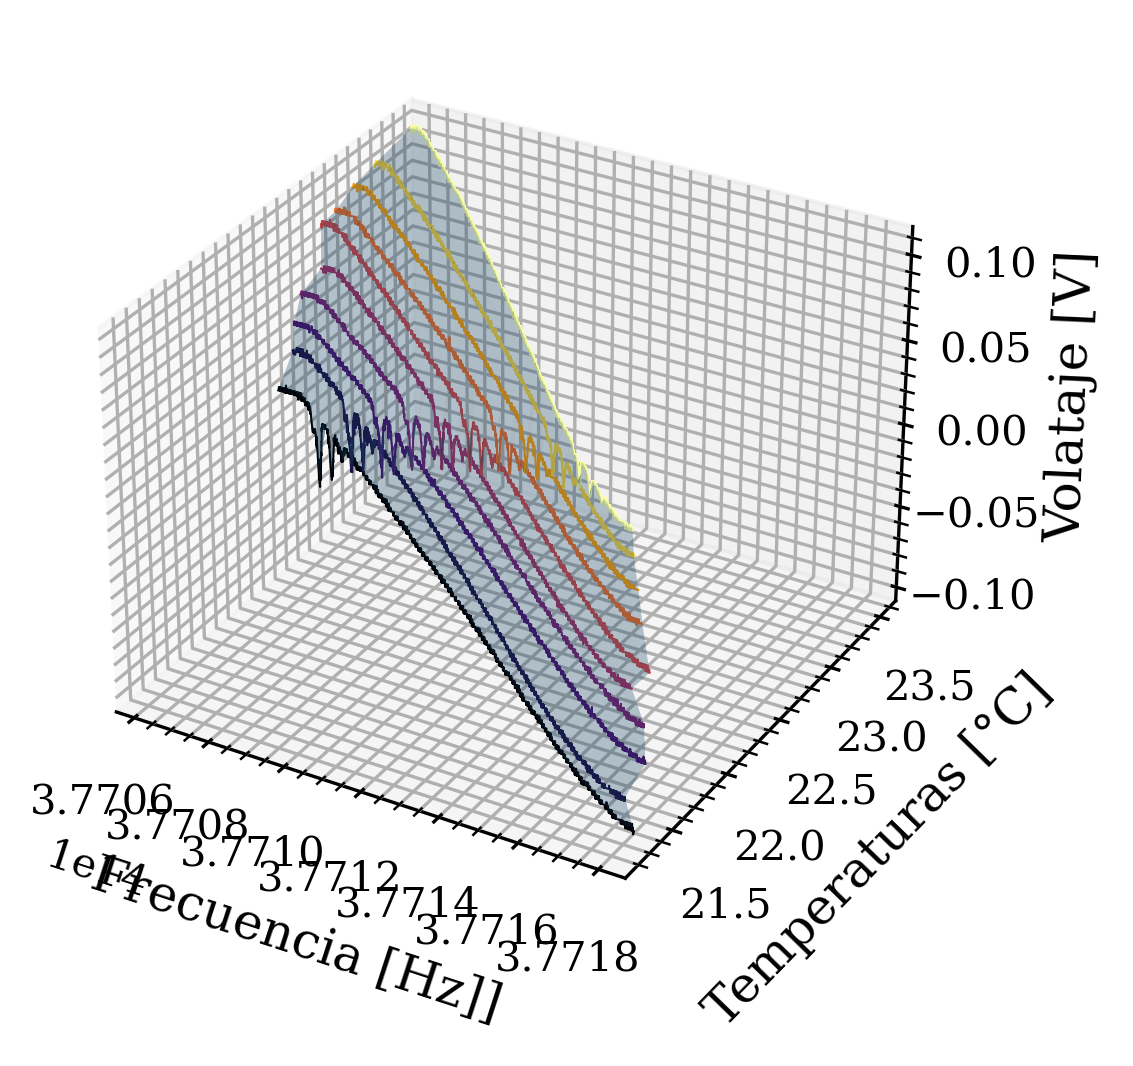

In [106]:
from matplotlib.colors import Normalize  # Para el coloreo dinamico

norm = Normalize(Temps_arr.min(), Temps_arr.max())  # Un normalizador que asocia valores del intervalo de n al rango [0:1].
warmscale = plt.cm.ScalarMappable(norm, 'inferno', )  # Asocio los valores del rango de n normalizado en [0:1] a una paleta de colores.
colors = warmscale.to_rgba  # la función que dado n devuelve el color asociado



fig = plt.figure(figsize=(8, 4), dpi=150)
ax = fig.add_subplot(projection='3d')


ax.plot_surface(freqs_arr, Temps_arr, V1, alpha=0.3)
for f, t, v in zip(freqs_arr, Temps_arr, V1):
    ax.plot(f, t, v, c=colors(t[0]), lw=0.5)
ax.set_xlabel("Frecuencia [Hz]]")
ax.set_ylabel("Temperaturas [°C]")
ax.set_zlabel("Volataje [V]")
plt.show()